In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from src.utils.paths import RESULTS_DIR
from sklearn.metrics import (
    precision_recall_curve, 
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)

### LOAD ALL METRICS AND COMBINE

In [55]:
#dataset = "ibtracs.last3years"
dataset = "ibtracs.ALL.list.v04r01"
baseline = pd.read_csv(RESULTS_DIR / dataset / "tables" / "baseline.csv")
traditional = pd.read_csv(RESULTS_DIR / dataset / "tables" / "traditional_fs.csv")
embedded = pd.read_csv(RESULTS_DIR / dataset / "tables" / "embedded_fs.csv")
optimization = pd.read_csv(RESULTS_DIR / dataset / "tables" / "optimization_fs.csv")
#xai = pd.read_csv(RESULTS_DIR / dataset / "tables" / "xai_fs.csv")

all_methods_combined = pd.concat([
    baseline, 
    traditional, 
    embedded, 
    #xai, 
    optimization
], ignore_index=True)

# Save combined
all_methods_combined.to_csv(RESULTS_DIR / dataset / "tables" / "all_methods_combined.csv", index=False)
results_path = RESULTS_DIR / dataset / "tables" / "all_methods_combined.csv"

### PERFORMANCE HEATMAP

In [56]:
def plot_performance_heatmap(model_name, results_path, save_path=None):
    """
    Heatmap showing all metrics for all methods.
    """
    # Load results CSV
    results = pd.read_csv(results_path)
    
    # Filter to one model (e.g., Random Forest)
    model_results = results[results['model'] == model_name]
    
    # Pivot: methods as rows, metrics as columns
    pivot = model_results.pivot_table(
        index='method',
        values=['accuracy', 'precision', 'recall', 'f1_score', 'auc'],
        aggfunc='max'
    )

    n_methods = len(pivot)
    height = max(6, n_methods * 0.5) 
    
    # Plot
    plt.figure(figsize=(10, height))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn',
               vmin=0.7, vmax=1.0, cbar_kws={'label': 'Score'})

    title = f"Performance Metrics Heatmap - {model_name}"
    plt.title(title, 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Metric', fontsize=14, fontweight='bold')
    plt.ylabel('Feature Selection Method', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

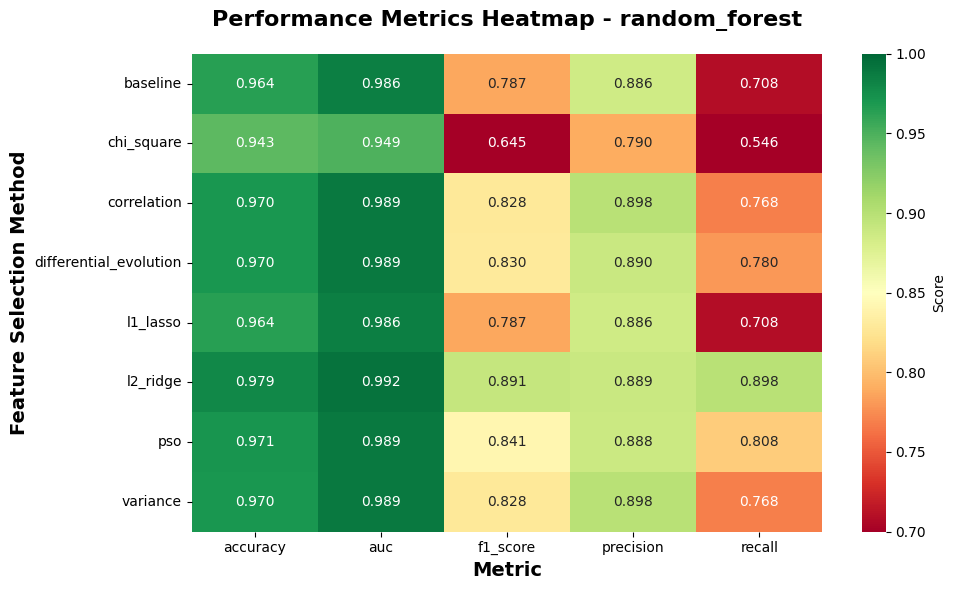

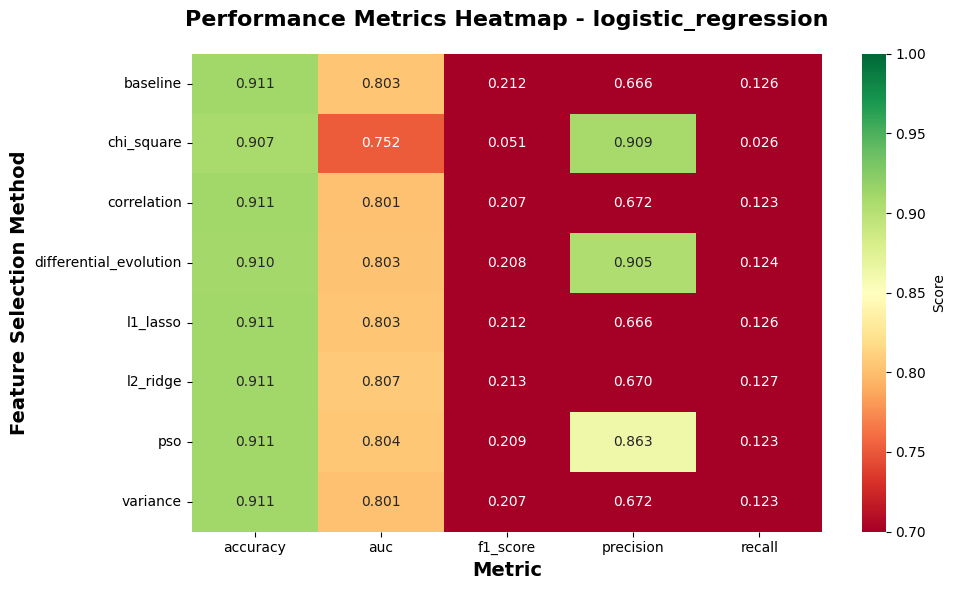

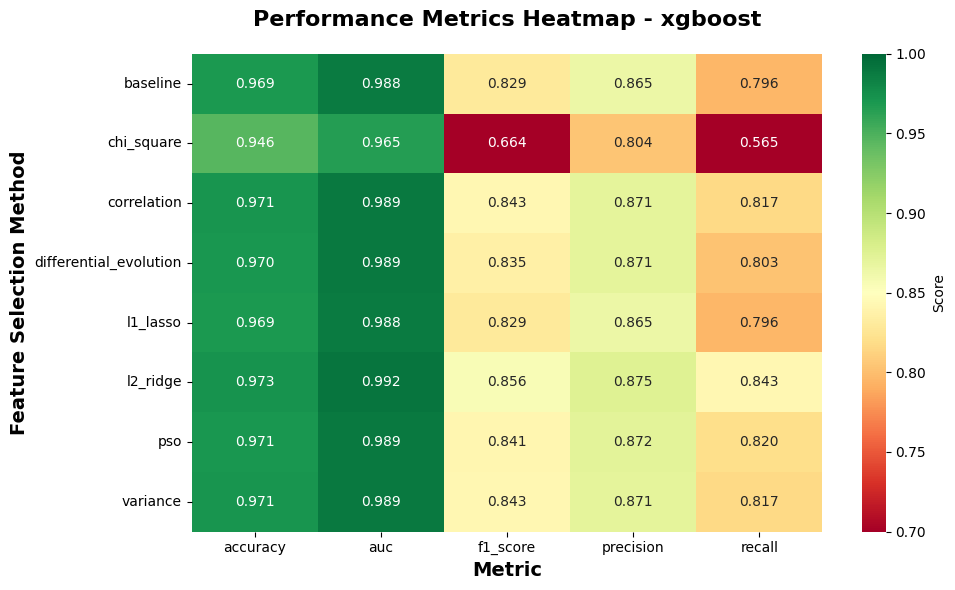

In [57]:
models = ['random_forest', 'logistic_regression', 'xgboost']
for model_name in models:
    path_value = RESULTS_DIR / dataset / "plots" / f"performance_heatmap_{model_name}.png"
    save_path = Path(path_value)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plot_performance_heatmap(model_name, results_path, save_path)

### LOAD PREDICTIONS

In [58]:
def load_predictions(method, dataset, model, n_features):
    """
    Load saved predictions.
    Parameters:
    - method: Feature selection method
    - dataset: Dataset name
    - model: Model name
    - n_features: Number of features used
    """
    pred_file = RESULTS_DIR / dataset / "predictions" / method / f"{model}_n{n_features}_predictions.json"  
    if not pred_file.exists():
        raise FileNotFoundError(f"Predictions not found: {pred_file}") 
    with open(pred_file, 'r') as f:
        data = json.load(f)
    return {
        'y_true': np.array(data['y_true']),
        'y_pred': np.array(data['y_pred']),
        'y_pred_proba': np.array(data['y_pred_proba'])
    }

# Load predictions for best F1 score.
def load_best_predictions(method, dataset, model):
    results_df = pd.read_csv(results_path)
    subset = results_df[
        (results_df['method'] == method) & 
        (results_df['model'] == model)
    ]
    best = subset.sort_values('f1_score', ascending=False).iloc[0]
    preds = load_predictions(method, dataset, model, int(best['n_features']))
    return preds, int(best['n_features'])

### PR-AUC SCORES COMPARISON (Bar Chart)

In [59]:
def plot_pr_auc_comparison(methods, dataset, models, save_path=None):
    """
    Compare PR-AUC scores across methods and models.
    """
    pr_aucs = []
    for method in methods:
        for model in models:
            preds, n_features = load_best_predictions(method, dataset, model)
            precision, recall, _ = precision_recall_curve(
                preds['y_true'], 
                preds['y_pred_proba']
            )
            pr_auc = auc(recall, precision)
            pr_aucs.append({
                'method': method,
                'model': model,
                'pr_auc': pr_auc,
                'n_features': n_features
            })
    
    df = pd.DataFrame(pr_aucs)
    # Plot grouped bar chart
    pivot = df.pivot(index='method', columns='model', values='pr_auc')
    ax = pivot.plot(kind='bar', figsize=(12, 6), width=0.8)
    for i, method in enumerate(pivot.index):
        for j, model in enumerate(pivot.columns):
            value = pivot.loc[method, model]
            n_feat = df[
                (df['method'] == method) &
                (df['model'] == model)
            ]['n_features'].values[0]
            ax.text(
                i + (j - len(pivot.columns)/2)*0.2,
                value,
                f"{n_feat}f",
                ha='center',
                va='bottom',
                fontsize=9
            )
    
    plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
    plt.ylabel('PR-AUC Score', fontsize=14, fontweight='bold')
    plt.title('PR-AUC Comparison Across Methods and Models', 
             fontsize=16, fontweight='bold', pad=20)
    plt.legend(title='Model', loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

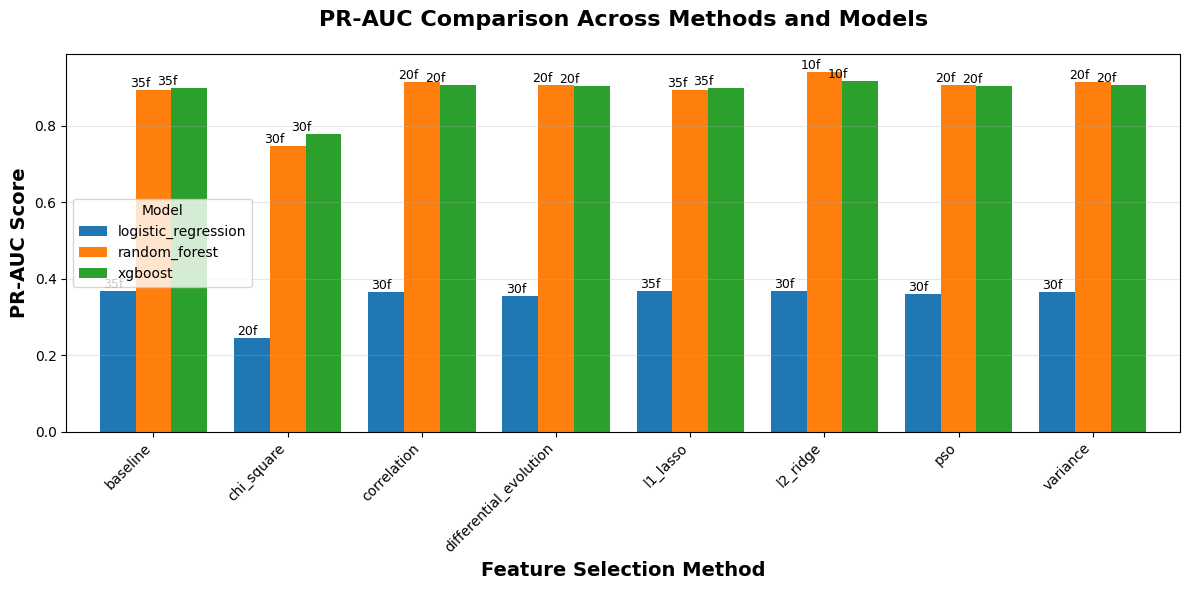

In [60]:
#methods = ['baseline', 'correlation', 'variance', 'chi_square', 
           #'l1_lasso', 'l2_ridge', 'shap', 'lime', 'pso', 'differential_evolution' ]
methods = ['baseline', 'correlation', 'variance', 'chi_square', 
           'l1_lasso', 'l2_ridge', 'pso', 'differential_evolution' ]
models = ['logistic_regression', 'random_forest', 'xgboost']
path_value = RESULTS_DIR / dataset / "plots" / "pr_auc_comparison.png"
save_path = Path(path_value)
save_path.parent.mkdir(parents=True, exist_ok=True)
plot_pr_auc_comparison(methods, dataset, models, save_path)

### PR-AUC CURVE

In [61]:
def plot_pr_curve(methods, dataset, model, save_path=None):
    """
    Plot Precision-Recall curve comparing different methods.
    """
    plt.figure(figsize=(10, 8))
    
    for method in methods:
        preds, n_features = load_best_predictions(method, dataset, model)
        # Calculate PR curve
        precision, recall, _ = precision_recall_curve(
            preds['y_true'], 
            preds['y_pred_proba']
        )
        pr_auc = auc(recall, precision)
        
        # Plot
        plt.plot(recall, precision, linewidth=2, 
                label=f'{method} (AUC={pr_auc:.3f}, n={n_features})')
    
    plt.xlabel('Recall', fontsize=14, fontweight='bold')
    plt.ylabel('Precision', fontsize=14, fontweight='bold')
    plt.title(f'Precision-Recall Curve - {model}', 
             fontsize=16, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

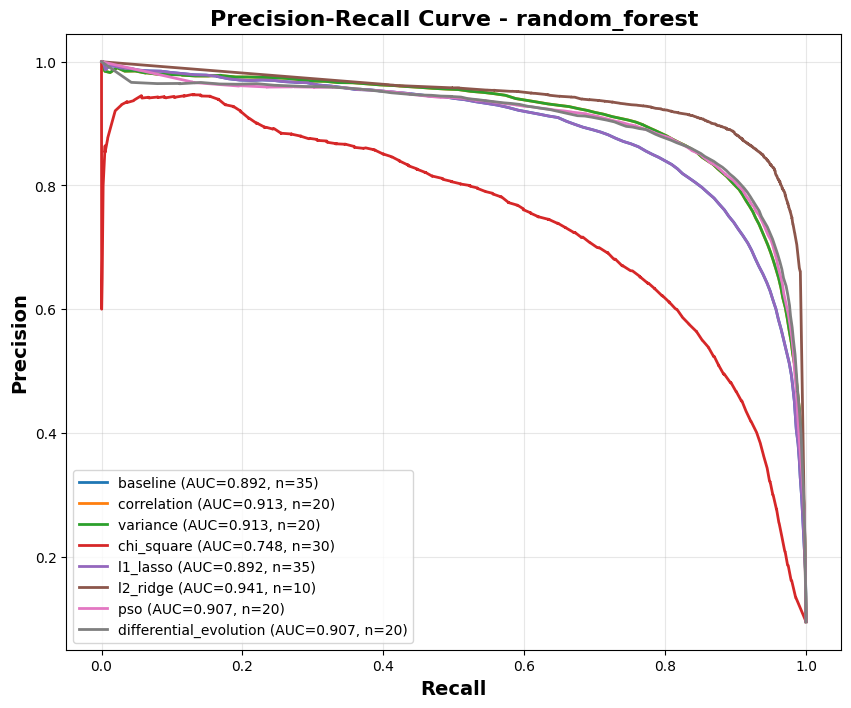

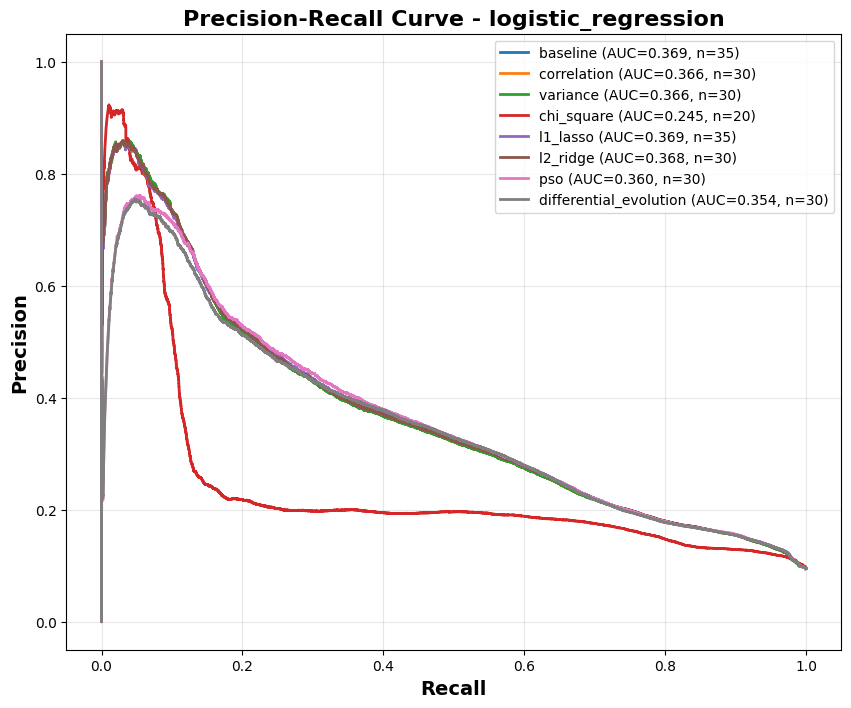

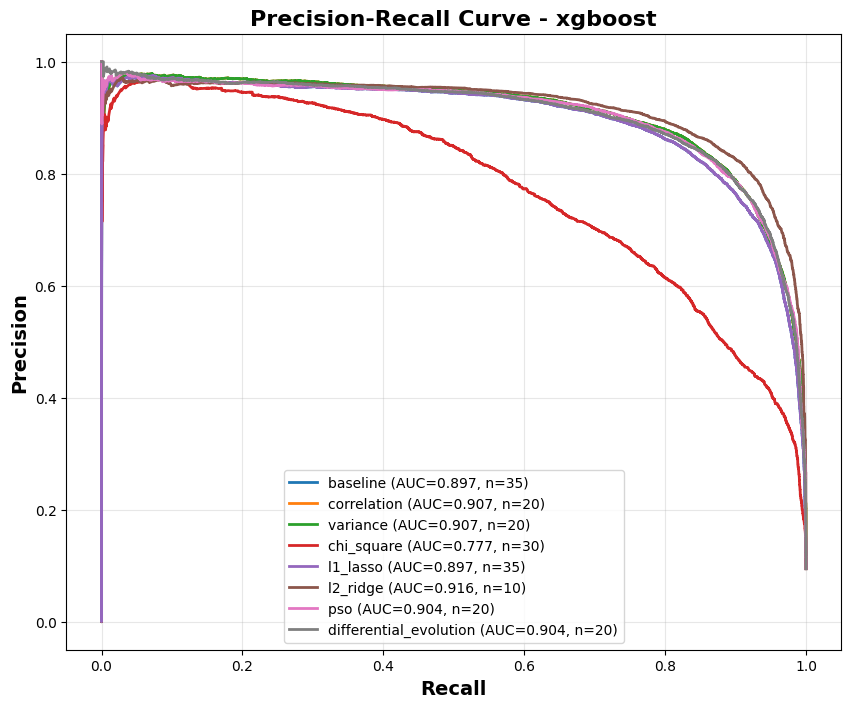

In [62]:
#methods = ['baseline', 'correlation', 'variance', 'chi_square', 
           #'l1_lasso', 'l2_ridge', 'shap', 'lime', 'pso', 'differential_evolution' ]
methods = ['baseline', 'correlation', 'variance', 'chi_square', 
           'l1_lasso', 'l2_ridge', 'pso', 'differential_evolution' ]
models = ['random_forest', 'logistic_regression', 'xgboost']
for model_name in models:
    save_path = Path(RESULTS_DIR / dataset / "plots" / f"pr_curve_{model_name}.png")
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plot_pr_curve(methods, dataset, model_name, save_path)

### CONFUSION MATRIX COMPARISON

In [63]:
def plot_confusion_matrices_grid(methods, dataset, model, save_path=None):
    """
    Plot confusion matrices for multiple methods in a grid.
    """
    n_methods = len(methods)
    cols = 3
    rows = (n_methods + 1) // 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 2.5*rows))
    
    # ALWAYS flatten, handle edge cases
    if rows * cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, method in enumerate(methods):
        preds, n_features = load_best_predictions(method, dataset, model)
        cm = confusion_matrix(preds['y_true'], preds['y_pred'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No', 'Yes'],
                   yticklabels=['No', 'Yes'],
                   ax=axes[idx], cbar=False)
        axes[idx].set_title(
            f'{method.replace("_", " ").title()} (n={n_features})',
            fontsize=12
        )
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    # Hide unused subplots
    for idx in range(n_methods, len(axes)):
        axes[idx].axis('off')
    
    # ADD MAIN TITLE ← ADD THIS
    model_display = model.replace('_', ' ').title()
    dataset_display = dataset.replace('_', ' ').replace('.', ' ').title()
    
    fig.suptitle(
        f'Confusion Matrices - {model_display}',
        fontsize=16,
        fontweight='bold',
        y=1.0  # Adjust vertical position if needed
    )
    
    plt.tight_layout()
    
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

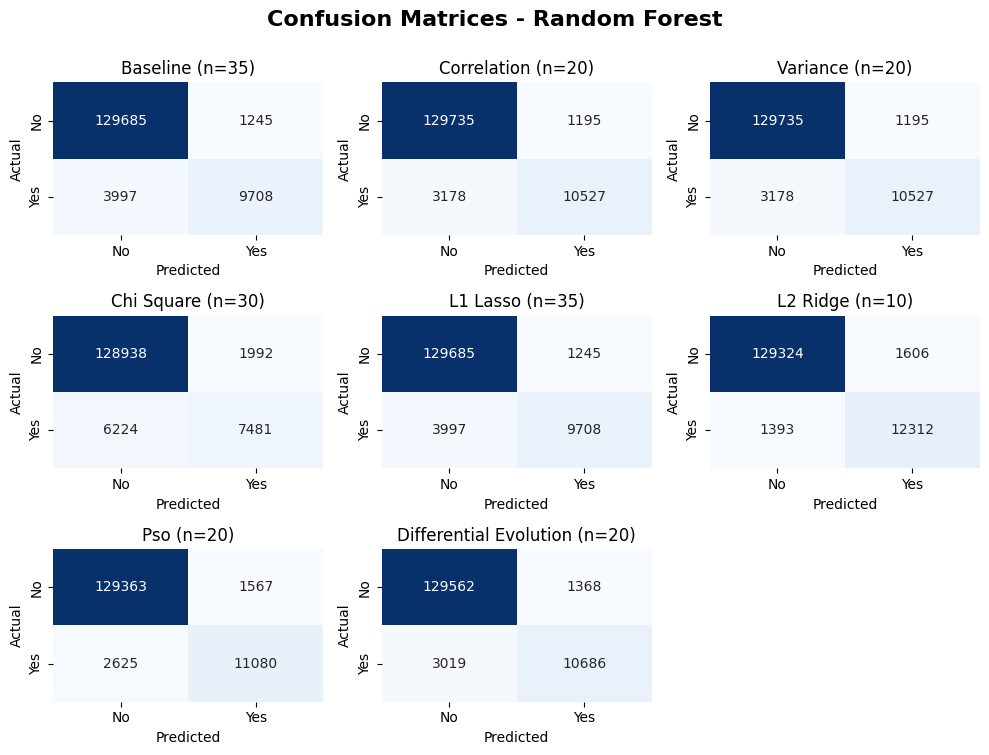

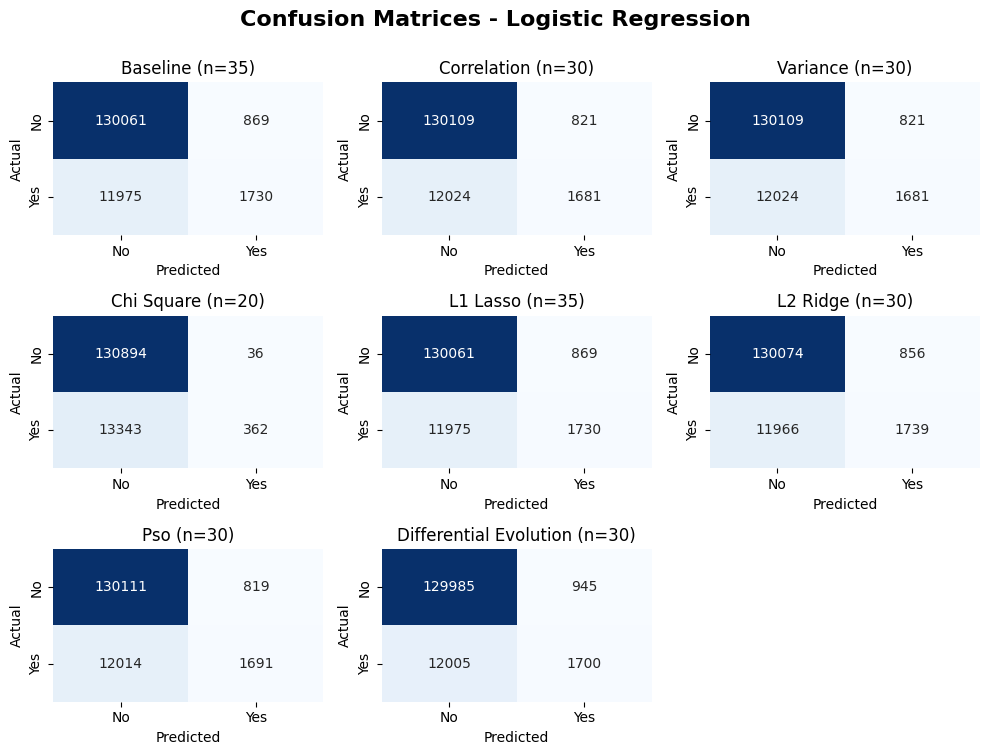

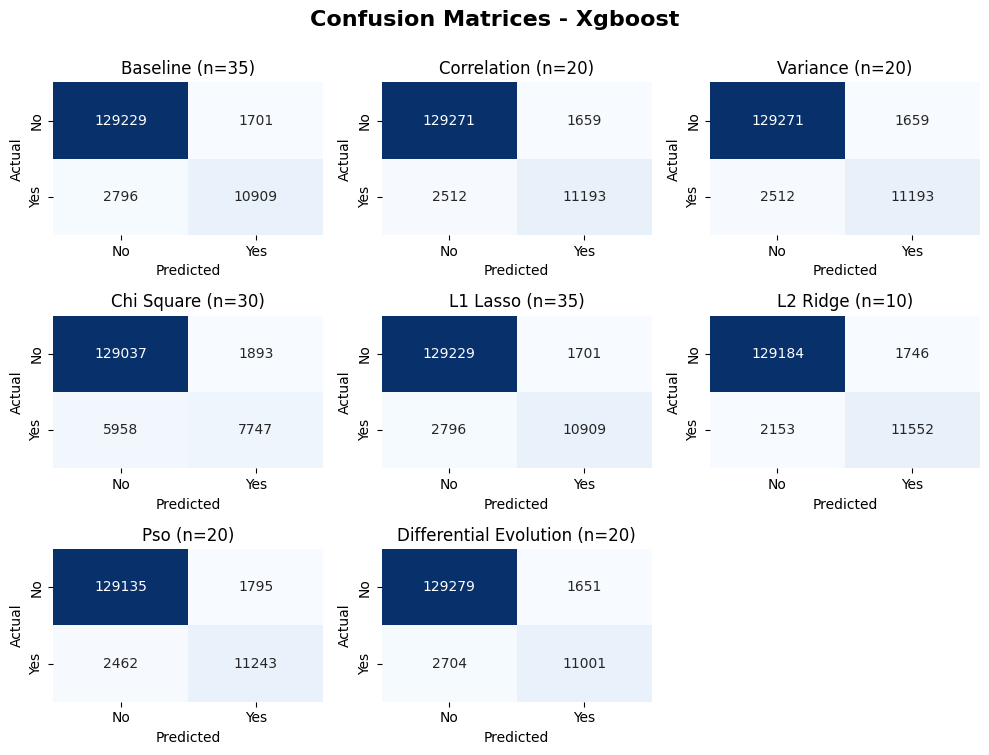

In [66]:
#methods = ['baseline', 'correlation', 'variance', 'chi_square', 
           #'l1_lasso', 'l2_ridge', 'shap', 'lime', 'pso', 'differential_evolution' ]
methods = ['baseline', 'correlation', 'variance', 'chi_square', 
           'l1_lasso', 'l2_ridge', 'pso', 'differential_evolution' ]
models = ['random_forest', 'logistic_regression', 'xgboost']
for model_name in models:
    save_path = Path(RESULTS_DIR / dataset / "plots" / f"cm_grid_{model_name}.png")
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plot_confusion_matrices_grid(methods, dataset, model_name, save_path)

### CONFUSION MATRIX HEATMAP

In [53]:
def plot_confusion_matrix(method, dataset, model, save_path=None):
    """
    Plot confusion matrix heatmap.
    """
    preds, n_features = load_best_predictions(method, dataset, model)
    
    # Calculate confusion matrix
    cm = confusion_matrix(preds['y_true'], preds['y_pred'])
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Landfall', 'Landfall'],
                yticklabels=['No Landfall', 'Landfall'],
                cbar_kws={'label': 'Count'})
    
    plt.xlabel('Predicted', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=14, fontweight='bold')
    plt.title(f'Confusion Matrix - {method} - {model}', 
             fontsize=16, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [81]:
"""
methods = ['baseline', 'correlation', 'variance', 'chi_square', 
           'l1_lasso', 'l2_ridge', 'shap', 'lime', 'pso', 'differential_evolution' ]
models = ['random_forest', 'logistic_regression', 'xgboost']
for model_name in models:
    for method in methods:
        save_path = Path(RESULTS_DIR / dataset / "plots" / f"cm_{method}_{model_name}.png")
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plot_confusion_matrix(method, dataset, model, save_path)
"""

'\nmethods = [\'baseline\', \'correlation\', \'variance\', \'chi_square\', \n           \'l1_lasso\', \'l2_ridge\', \'shap\', \'lime\', \'pso\', \'differential_evolution\' ]\nmodels = [\'random_forest\', \'logistic_regression\', \'xgboost\']\nfor model_name in models:\n    for method in methods:\n        save_path = Path(RESULTS_DIR / dataset / "plots" / f"cm_{method}_{model_name}.png")\n        save_path.parent.mkdir(parents=True, exist_ok=True)\n        plot_confusion_matrix(method, dataset, model, save_path)\n'